## Modulimport

In [1]:
%matplotlib notebook
import numpy as np
import pandas as pd
import time

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

## Daten Laden
Als erstes Laden wir die Daten aus der Datei `pandas_1.hdf`

In [2]:
data = pd.read_hdf('pandas_1.hdf', 'data')
data.head()

,Rohrnummer,Feature,Messwert
0,43623690,Blockgewicht,145.2
1,43623757,Blockgewicht,143.0
2,43623816,Blockgewicht,145.0
3,43623879,Blockgewicht,144.2
4,43623899,Blockgewicht,143.4


## A1: Daten Vorverarbeiten
##### 1. Setze den Index auf die Spalte ``Rohrnummer``

In [3]:
data_1 = data.set_index('Rohrnummer')

##### 2. Sortiere den DataFrame so um, dass für jedes ``Feature`` eine Spalte erzeugt wird. (Hinweis: Pivot)

In [4]:
data_processed = data_1.pivot(columns='Feature', values='Messwert')
data_processed.head()

Feature,Blockgewicht,Ofen_Verweilzeit,Zunderverlust
Rohrnummer,,,
43623690,145.2,4467.0,1.166
43623757,143.0,4631.0,1.184
43623816,145.0,NaN,NaN
43623879,144.2,NaN,NaN
43623899,143.4,NaN,NaN


##### 3. Wie viele NaN Werte kommen je Spalte vor?

In [5]:
data_processed.isna().sum(axis=0)

Feature
Blockgewicht          93
Ofen_Verweilzeit    6841
Zunderverlust       6085
dtype: int64

## A2: Daten Auswerten

##### 4. Stelle in einem Scatter-Plot den Zusammenhang zwischen ``Blockgewicht_``  und ``Zunderverlust`` grafisch da
Verwende hierzu einerseits die funktion ``plt.scatter()`` und andererseits ``sns.jointplot()`` mit dem zusätlichen Keyword-Argument ``kind='kde'``.

<IPython.core.display.Javascript object>


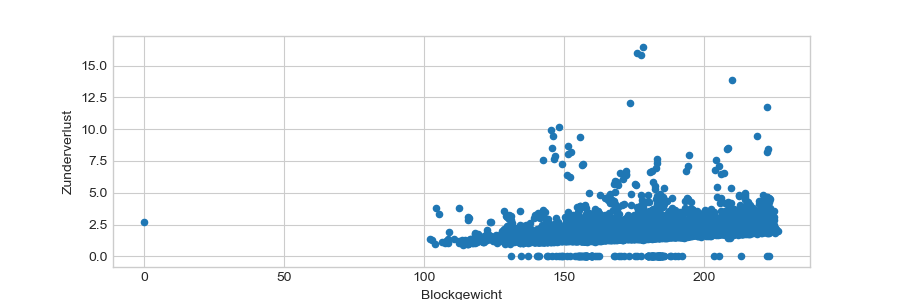

In [6]:
data_processed.plot.scatter('Blockgewicht', 'Zunderverlust', figsize=(9, 3))

<IPython.core.display.Javascript object>


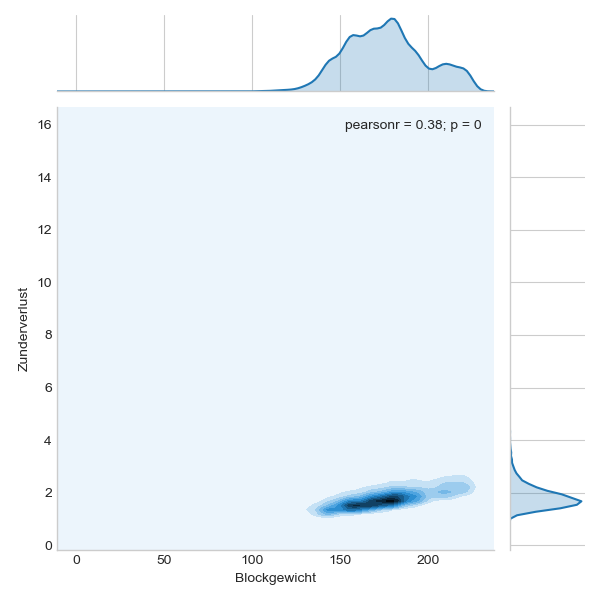

C:\Users\thielc\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


In [7]:
sns.jointplot(data_processed.Blockgewicht, data_processed.Zunderverlust, kind='kde')

##### 5. Berechne die Korrelation zwischen ``Blockgewicht``  und ``Zunderverlust`` 

In [8]:
data_processed.corr()

Feature,Blockgewicht,Ofen_Verweilzeit,Zunderverlust
Feature,,,
Blockgewicht,1.000000,0.013646,0.384581
Ofen_Verweilzeit,0.013646,1.000000,0.818238
Zunderverlust,0.384581,0.818238,1.000000


###### 6. Wahrscheinlichkeitsdichte Schätzen.
Schätze nun die Parameter $\mu$ und $\sigma$ für eine Normalverteilung für ``Zunderverlust``. Stelle anschließend die geschätzte Normalverteilung zusammen mit den Daten in einem Histogramm graphisch da.

Hinweis: Funktionen zum fitten und berechnen diverser Verteilungen sind in dem Paket ``scipy.stats`` verfügbar. (z.b. ``scipy.stats.norm`` für Normalverteilungen). Die Dokumentation ist online verfügbar:
https://docs.scipy.org/doc/scipy/reference/stats.html

<IPython.core.display.Javascript object>


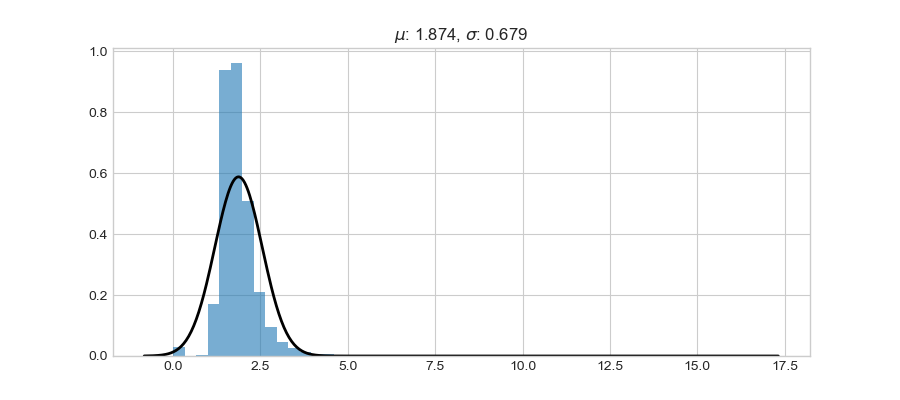

Text(0.5,1,'$\\mu$: 1.874, $\\sigma$: 0.679')

In [9]:
import scipy.stats as stat
mean, std_dev = stat.norm.fit(data_processed.Zunderverlust.dropna())

# Plot the histogram.
plt.figure(figsize=(9,4))
plt.hist(data_processed.Zunderverlust.dropna(), bins=50, density=True, alpha=0.6)

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 500)
p = stat.norm.pdf(x, mean, std_dev)
plt.plot(x, p, 'k', linewidth=2)
title = f"$\mu$: {mean:.3f}, $\sigma$: {std_dev:.3f}"
plt.title(title)

##### 6. Bonusaufgabe: Robust Polyfit
Wir versuchen nun den Zusammenhang zwischen Blockgewicht und Zunderverlust robust linear zu modellieren. Verwende hierzu einerseits die Funktion den RANSAC-Regressor im Paket ``sklearn``. (``from sklearn.linear_model import RANSACRegressor``).
Stelle anschließend die Regressionsgerade in einem Plot graphisch dar.

Dokumentation: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RANSACRegressor.html

Hinweise:
* Entferne zunächst fehlende Zeilen aus dem DataFrame (Tipp: ``.dropna()``)
* Die .fit()-Methode benötigt einen 2-Dimensionalen Eingang.
* Für bessere Ergebnisse initalisiere den RANSACRegressor mit dem optionalen keyword-argument ``resudual_treshold`` wie folgt: ``RANSACRegressor(residual_threshold=1)``

<IPython.core.display.Javascript object>


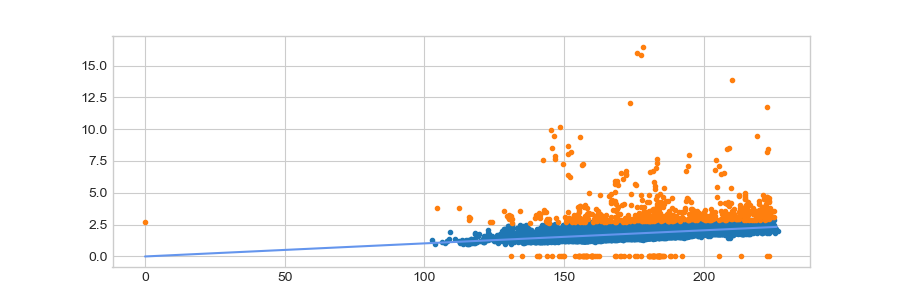

In [10]:
from sklearn.linear_model import RANSACRegressor

# Robustly fit linear model with RANSAC algorithm
data_clean = data_processed.dropna()
X = data_clean.Blockgewicht
y = data_clean.Zunderverlust

# RANSAC
ransac = RANSACRegressor(residual_threshold=1)
ransac.fit(X.values.reshape([-1, 1]), y)
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

# Predict data of estimated models
line_X = np.arange(X.min(), 
                   X.max())[:, np.newaxis]
line_y_ransac = ransac.predict(line_X)

# Plot
plt.figure(figsize=(9,3))
plt.scatter(X[inlier_mask], y[inlier_mask], marker='.',
            label='Inliers')
plt.scatter(X[outlier_mask], y[outlier_mask],marker='.',
            label='Outliers')
plt.plot(line_X, line_y_ransac, color='cornflowerblue', label='RANSAC regressor')